# All Import-Statements

In [626]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import os
from pymol import cmd
from collections import defaultdict, Counter 
from sklearn.preprocessing import MinMaxScaler
from Bio.SeqUtils import seq1
from Bio import SeqIO # to read sequences from a FASTA file
from Bio import pairwise2 # pairwise sequence alignments
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.cm as cm
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import mannwhitneyu


import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['axes.titleweight'] = 'bold'


# Data Clean Up 

In [627]:
# Define datasets for individual inhibitory checkpoints
data = pd.read_csv('data/ab_ag.tsv', sep='\t')
pd1 = data[data['compound'].str.contains('PD-1', na=False)]
pdl1 = data[data['compound'].str.contains('PD-L1', na=False)]
ctla4 = data[data['compound'].str.contains('CTLA-4', na=False)]
kir = data[data['compound'].str.contains('KIR', na=False)]
lag3 = data[data['compound'].str.contains('LAG', na=False)]
tim3 = data[data['compound'].str.contains('TIM3', na=False)]

In [628]:
# Filter out necessary columns
pd1 = pd1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
pdl1 = pdl1[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
ctla4 = ctla4[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
kir = kir[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
lag3 = lag3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]
tim3 = tim3[['pdb', 'Hchain', 'Lchain', 'antigen_chain', 'antigen_type', 'antigen_name', 'compound', 'resolution', 'method']]

In [629]:
combined_dataset = [pdl1, pd1, ctla4, kir, lag3, tim3]

# Shuffle the list randomly
random.shuffle(combined_dataset)

# Concatenate them in the new random order
merged_df = pd.concat(combined_dataset, ignore_index=True)
shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)

In [630]:
shuffled_df = shuffled_df[shuffled_df['resolution'] < 3.5]
shuffled_df = shuffled_df.dropna()

In [631]:
l = ['CTLA-4', 'TIM3', 'PD-1', 'PD-L1', 'KIR', 'LAG3']

cp_cout_df = pd.DataFrame(index = l)

for item in l:
    count = shuffled_df[shuffled_df['compound'].str.contains(item, na=False)].shape[0]
    cp_cout_df.loc[item, 'count'] = count

cp_cout_df = cp_cout_df.reset_index()
cp_cout_df.columns = ['checkpoint', 'count'] 

In [632]:
# 1. Filter all relevant rows: those with 'mab' OR 'M6903'
ab_mask = shuffled_df['compound'].str.contains('mab|M6903', na=False, case=False)
shuffled_df_ab = shuffled_df[ab_mask]

# 2. Extract antibody names
shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)

# 3. Fill in M6903 manually where missing
m6903_mask = shuffled_df_ab['compound'].str.contains('M6903', na=False)
shuffled_df_ab.loc[m6903_mask, 'antibody'] = shuffled_df_ab.loc[m6903_mask, 'antibody'].fillna('M6903')

# # 4. Extract checkpoint names
checkpoints_pattern = r'\b(PD-1|PD-L1|CTLA-4|KIR2DL3|TIM3)\b'
shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)

# # 5. Final formatting
shuffled_df_ab = shuffled_df_ab[['antibody', 'checkpoint', 'pdb', 'Hchain', 'Lchain', 'antigen_chain']]
shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

shuffled_df_ab

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/60524799.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['antibody'] = shuffled_df_ab['compound'].str.extract(r'\b(\w*mab)\b', expand=False)
/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/60524799.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shuffled_df_ab['checkpoint'] = shuffled_df_ab['compound'].str.extract(checkpoints_pattern, expand=False)


,antibody,checkpoint,pdb,Hchain,Lchain,antigen_chain
1,PEMBROLIZUMAB,PD-1,5b8c,B,A,C
2,IPILIMUMAB,CTLA-4,5xj3,D,E,F
3,CEMIPLIMAB,PD-1,7wvm,A,B,E
4,IPILIMUMAB,CTLA-4,7su0,I,M,D
5,CAMRELIZUMAB,PD-1,7cu5,B,B,E
7,TISLELIZUMAB,PD-1,7bxa,B,C,A
9,ATEZOLIZUMAB,PD-L1,5x8l,G,L,B
10,PEMBROLIZUMAB,PD-1,5ggs,C,D,Y
11,CEMIPLIMAB,PD-1,8gy5,H,L,P
13,IPILIMUMAB,CTLA-4,9dq3,H,L,C


In [633]:
pdb_list = shuffled_df_ab['pdb'].unique().tolist()
#shuffled_df_ab['antibody'] = shuffled_df_ab['antibody'].str.upper()

with open('pdb_list.txt', 'w') as f:
    for pdb in pdb_list:
        f.write(pdb + '\n')

In [634]:
# make a list of the columns 
shuffled_df_ab = shuffled_df_ab[['pdb', 'Hchain', 'Lchain', 'antigen_chain']]
extracted_list = shuffled_df_ab.values.tolist()

extracted_list


[['5b8c', 'B', 'A', 'C'],
 ['5xj3', 'D', 'E', 'F'],
 ['7wvm', 'A', 'B', 'E'],
 ['7su0', 'I', 'M', 'D'],
 ['7cu5', 'B', 'B', 'E'],
 ['7bxa', 'B', 'C', 'A'],
 ['5x8l', 'G', 'L', 'B'],
 ['5ggs', 'C', 'D', 'Y'],
 ['8gy5', 'H', 'L', 'P'],
 ['9dq3', 'H', 'L', 'C'],
 ['5tru', 'h', 'l', 'c'],
 ['5ggr', 'A', 'B', 'Y'],
 ['5xj4', 'H', 'L', 'A'],
 ['6txz', 'H', 'L', 'A'],
 ['5x8m', 'B', 'C', 'A'],
 ['5b8c', 'E', 'D', 'F'],
 ['6xkr', 'H', 'L', 'P'],
 ['8gy5', 'A', 'B', 'Q'],
 ['7bxa', 'H', 'L', 'P'],
 ['7cgw', 'H', 'L', 'P'],
 ['6txz', 'J', 'N', 'C'],
 ['7cu5', 'A', 'A', 'Q'],
 ['5wt9', 'H', 'L', 'G'],
 ['5x8l', 'H', 'M', 'C'],
 ['6k0y', 'A', 'B', 'C'],
 ['5x8l', 'S', 'N', 'D'],
 ['5jxe', 'D', 'C', 'B'],
 ['7su0', 'H', 'L', 'C'],
 ['5xj3', 'G', 'H', 'I'],
 ['8tui', 'H', 'L', 'A'],
 ['5ggr', 'H', 'L', 'Z'],
 ['6rp8', 'h', 'l', 'c'],
 ['5b8c', 'H', 'G', 'I'],
 ['5xxy', 'H', 'L', 'A'],
 ['7wsl', 'H', 'L', 'D'],
 ['5jxe', 'G', 'F', 'A'],
 ['9dq4', 'H', 'L', 'A'],
 ['7wvm', 'C', 'D', 'F'],
 ['5xj3', 'J

# Paratope, Hydrogen-Bonds, Saltbridges

In [ ]:
results = []
section = 'paratope' # paste 'paratope' or 'epitope'; please select one of the two sections
# input 
root_folder = "structures"
cutoff_distance = 5.0  # in Å distance
hbond_cutoff = 3.5  # in Å distance for hydrogen bonds
salt_cutoff = 4.0  # in Å distance for salt bridges

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data if available

# Extracted list: [pdb_id, H_chain, L_chain, antigen_chain]

# Loop over each chain combination from the extracted list
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

        cmd.reinitialize()
        cmd.load(pdb_path)

        # Selections
        cmd.select("antibody", f"chain {h_chain}+{l_chain}")
        cmd.select("antigen", f"chain {ag_chain}")
        if section == 'paratope':
            cmd.select(f"{section}", f"antibody within {cutoff_distance} of antigen")
        else:
            cmd.select(f"{section}", f"antigen within {cutoff_distance} of antibody")
        # Color antibody chains 
        cmd.color("marine", f"chain {h_chain}")
        cmd.color("skyblue", f"chain {l_chain}")

        # Color antigen chain 
        cmd.color("salmon", "antigen")

        # Highlight paratope/epitope
        cmd.color("yellow", f"{section}")

        # Surface area
        paratope_area = cmd.get_area(f"{section}")
        print(f" Epitope surface area: {paratope_area:.2f} Å²")

        # Hydrogen bonds
        hbonds = cmd.find_pairs("antibody", "antigen", mode=1, cutoff=hbond_cutoff)
        num_hbonds = len(hbonds)
        print(f"Found {num_hbonds} hydrogen bonds at the interface.")

        # salt bridges 
        # antibody acidic O  → antigen basic N
        cmd.select("acidic_ab", f"chain {h_chain}+{l_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ag",  f"chain {ag_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb1 = cmd.find_pairs("acidic_ab", "basic_ag", cutoff=salt_cutoff, mode=1)

        # antigen acidic O → antibody basic N
        cmd.select("acidic_ag", f"chain {ag_chain} and resn ASP+GLU "
                                "and name OD1+OD2+OE1+OE2")
        cmd.select("basic_ab",  f"chain {h_chain}+{l_chain} and resn LYS+ARG+HIS "
                                "and name NZ+NH1+NH2+ND1+NE2")
        sb2 = cmd.find_pairs("acidic_ag", "basic_ab", cutoff=salt_cutoff, mode=1)

        # cleanup salt-bridge selections
        for sel in ("acidic_ab","basic_ag","acidic_ag","basic_ab"):
            cmd.delete(sel)

        num_salt_bridges = len(sb1) + len(sb2)
        print(f"   ➤ Salt bridges: {num_salt_bridges}")

        # save session 
        session_out = os.path.join(dirpath, f"{pdb_id}_{section}.pse")
        cmd.save(session_out)

        # collect results 
        results.append({
            "pdb_id":              pdb_id,
            "H_chain":             h_chain,
            "L_chain":             l_chain,
            "antigen_chain":       ag_chain,
            f"{section}_area":       paratope_area,
            "num_hydrogen_bonds":  num_hbonds,
            "num_salt_bridges":    num_salt_bridges,
            "folder":              os.path.basename(dirpath)
        })

# Save to CSV
df_struc_info = pd.DataFrame(results)

# Save results to CSV 
df_struc_info = pd.DataFrame(results)
df_struc_info.to_csv(f"{section}_surface_hbonds_salt_bridges_summary.csv", index=False)

print(f"Results saved to '{section}_surface_hbonds_salt_bridges_summary.csv'")

Processing 5b8c...
 Epitope surface area: 1872.03 Å²
Found 32 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5xj3...
 Epitope surface area: 1529.39 Å²
Found 20 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7wvm...
 Epitope surface area: 1114.70 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 7su0...
 Epitope surface area: 1668.17 Å²
Found 16 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 7cu5...
 Epitope surface area: 713.16 Å²
Found 8 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 7bxa...
 Epitope surface area: 1424.01 Å²
Found 24 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5x8l...
 Epitope surface area: 1699.88 Å²
Found 26 hydrogen bonds at the interface.
   ➤ Salt bridges: 0
Processing 5ggs...
 Epitope surface area: 1861.32 Å²
Found 31 hydrogen bonds at the interface.
   ➤ Salt bridges: 1
Processing 8gy5...
 Epitope surface area: 1210.95 Å²
Found 19 hydrogen bon

In [636]:
df_struc_info = pd.read_csv(f"{section}_surface_hbonds_salt_bridges_summary.csv")
print(df_struc_info['pdb_id'].value_counts())

pdb_id
5x8l    5
5b8c    4
5xj3    4
6txz    4
8gy5    2
7cgw    2
5ggr    2
6rp8    2
5tru    2
5ggs    2
7bxa    2
7cu5    2
7su0    2
7wvm    2
5jxe    2
5grj    1
7su1    1
9dq4    1
7wsl    1
5xxy    1
5x8m    1
8tui    1
6k0y    1
5wt9    1
6xkr    1
5xj4    1
9dq3    1
5ggv    1
Name: count, dtype: int64


## Plotting the results 

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

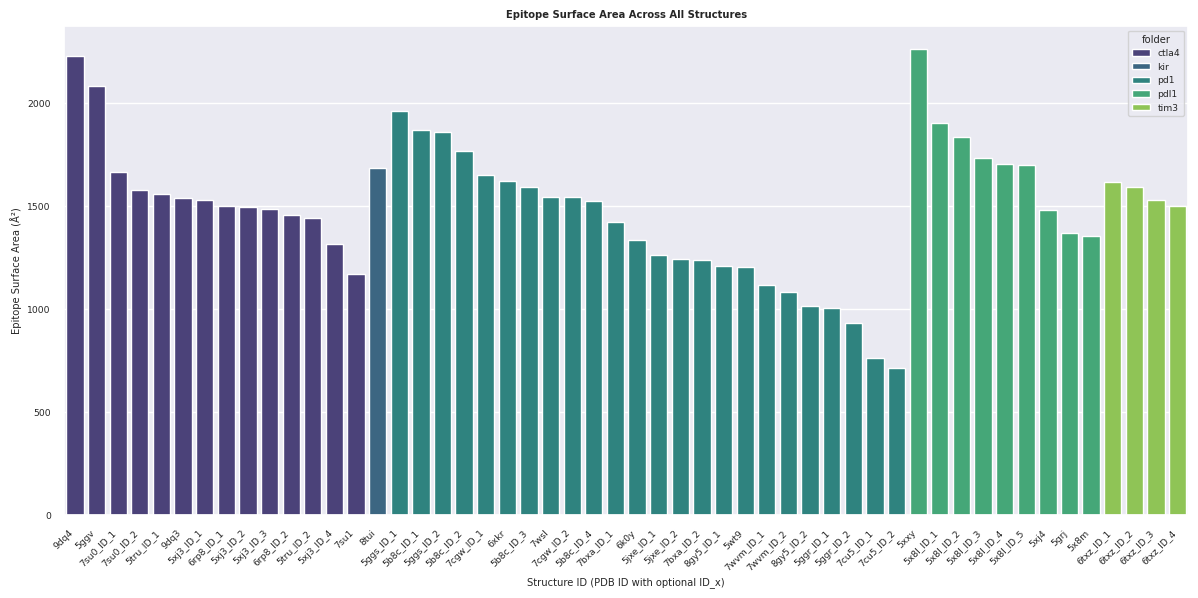

In [637]:
# Sort as before
df_sorted = df_struc_info.sort_values(by=["folder", f"{section}_area"], ascending=[True, False]).copy()


# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted["structure_id"] = structure_ids

# Plotting 
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y=f"{section}_area", hue="folder", dodge=False, palette="viridis")


plt.title(f"{section.capitalize()} Surface Area Across All Structures")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel(f"{section.capitalize()} Surface Area (Å²)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section}_surface_area_across_all_structures.pdf', bbox_inches='tight')
plt.show()



findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

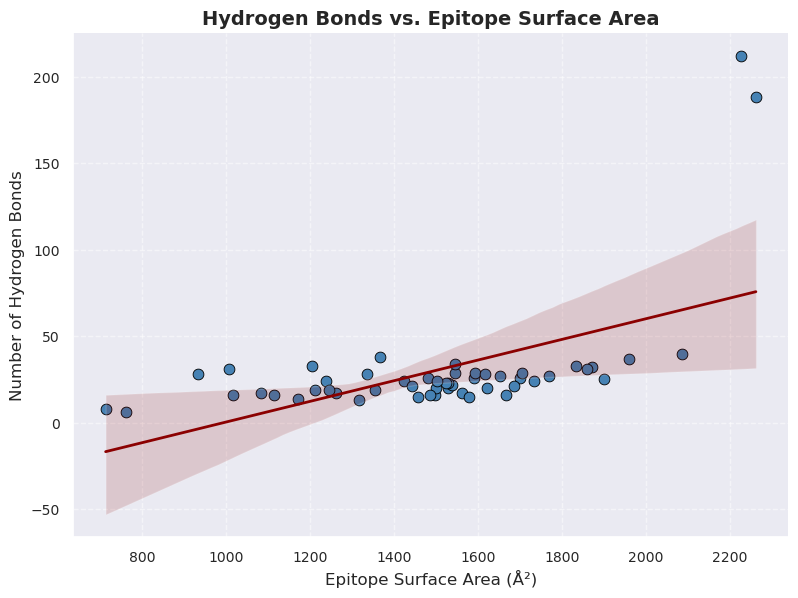

In [638]:
df_struc_info = pd.read_csv(f"{section}_surface_hbonds_salt_bridges_summary.csv")

plt.figure(figsize=(8, 6))

# Scatterplot
sns.scatterplot(
    data=df_struc_info,
    x=f"{section}_area",
    y="num_hydrogen_bonds",
    s=60,
    color="steelblue",
    edgecolor="black"
)

# Regression line
sns.regplot(
    data=df_struc_info,
    x=f"{section}_area",
    y="num_hydrogen_bonds",
    scatter=False,
    color="darkred",
    line_kws={'linewidth': 2}
)

# Styling
plt.title(f"Hydrogen Bonds vs. {section.capitalize()} Surface Area", fontsize=14, fontweight="bold")
plt.xlabel(f"{section.capitalize()} Surface Area (Å²)", fontsize=12)
plt.ylabel("Number of Hydrogen Bonds", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()

# Save
plt.savefig(f"plots/structural_analysis/{section}_hbonds_vs_surface_area.pdf", bbox_inches='tight')
plt.show()


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

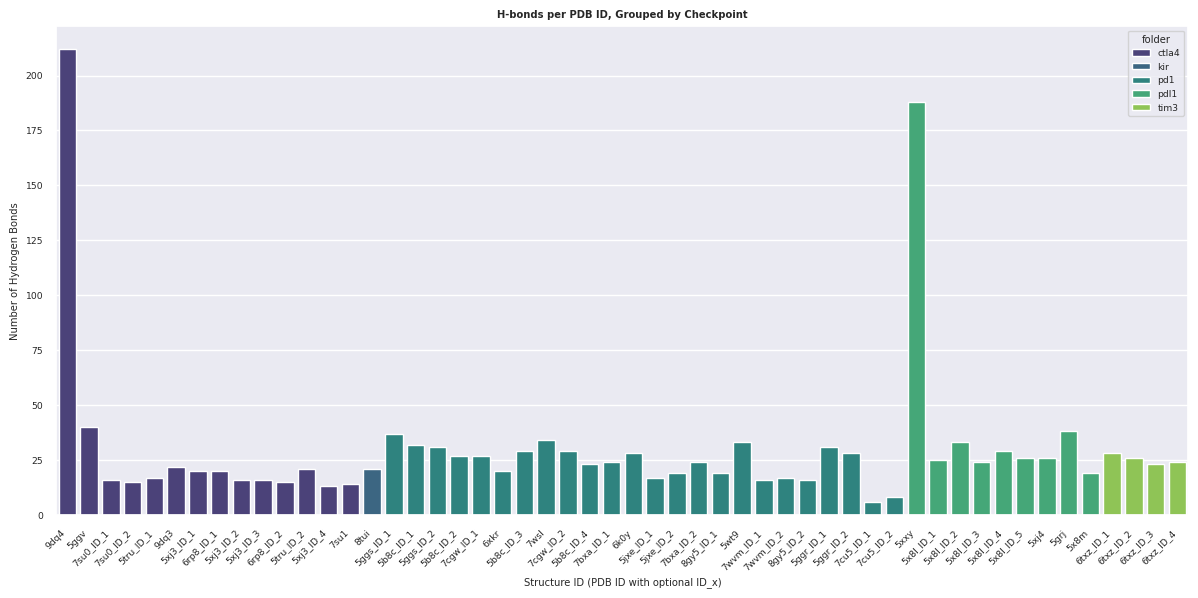

In [639]:
df_sorted_h = df_struc_info.sort_values(by=["folder", "num_hydrogen_bonds"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_h["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_h["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_h["structure_id"] = structure_ids

# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="structure_id", y="num_hydrogen_bonds", hue="folder", dodge=False, palette="viridis")

plt.title("H-bonds per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Hydrogen Bonds")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section}_h_bonds_per_PDB.pdf', bbox_inches='tight')
plt.show()

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

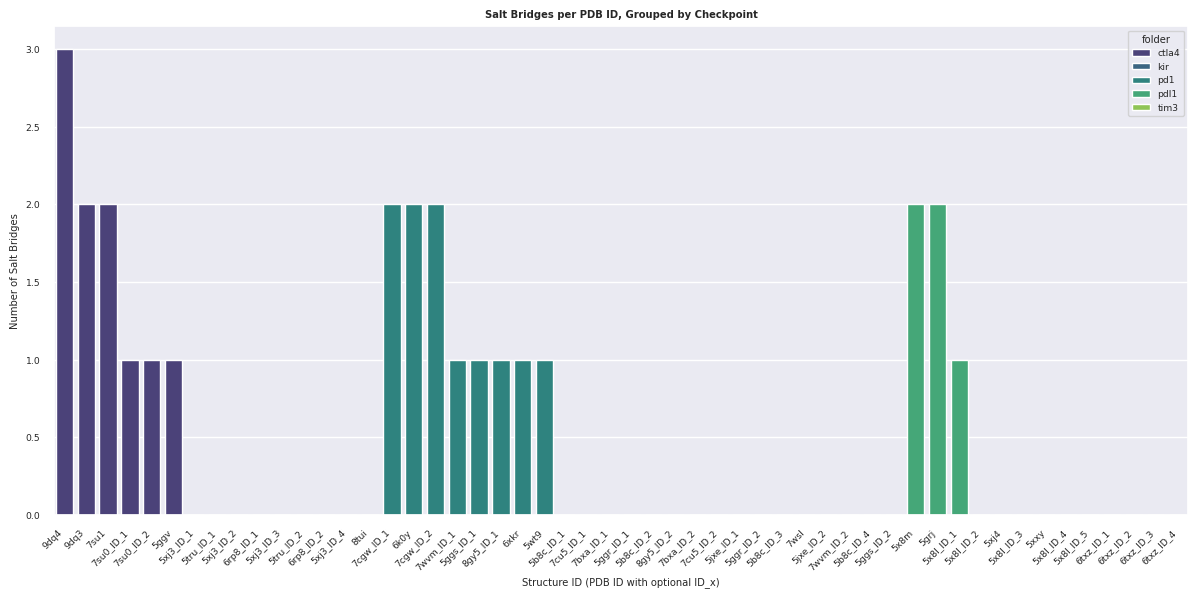

In [640]:

df_sorted_s = df_struc_info.sort_values(by=["folder", "num_salt_bridges"], ascending=[True, False]).copy()

# Count how many times each pdb_id appears
id_frequencies = Counter(df_sorted_s["pdb_id"])
id_tracker = defaultdict(int)

# Build structure_id column
structure_ids = []

for pdb_id in df_sorted_s["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_sorted_s["structure_id"] = structure_ids


# Plotting (same as before)
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted_s, x="structure_id", y="num_salt_bridges", hue="folder", dodge=False, palette="viridis")

plt.title("Salt Bridges per PDB ID, Grouped by Checkpoint")
plt.xlabel("Structure ID (PDB ID with optional ID_x)")
plt.ylabel("Number of Salt Bridges")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f'plots/structural_analysis/{section}salt_bridges_per_PDB.pdf', bbox_inches='tight')
plt.show() 



# Binding Score 

In [641]:

#normalizing with MinMax
scaler = MinMaxScaler()
df = pd.read_csv(f"{section}_surface_hbonds_salt_bridges_summary.csv")
features = df[["num_hydrogen_bonds", "num_salt_bridges", f"{section}_area"]]
normalized = scaler.fit_transform(features)

df_norm = pd.DataFrame(normalized, columns=features.columns)
df_norm["pdb_id"] = df["pdb_id"]  

# Create a binding strength score
weights = {
    "num_hydrogen_bonds": 0.4,
    "num_salt_bridges": 0.4,
    f"{section}_area": 0.2
}

df_norm["binding_score"] = (
    df_norm["num_hydrogen_bonds"] * weights["num_hydrogen_bonds"] +
    df_norm["num_salt_bridges"] * weights["num_salt_bridges"] +
    df_norm[f"{section}_area"] * weights[f"{section}_area"]
)

# Show top binders
print(df_norm.sort_values("binding_score", ascending=False)[["pdb_id", "binding_score"]])


   pdb_id  binding_score
36   9dq4       0.995573
33   5xxy       0.553398
51   7cgw       0.428643
19   7cgw       0.418769
47   5grj       0.413341
9    9dq3       0.404239
24   6k0y       0.389920
49   5ggv       0.376486
14   5x8m       0.374642
39   7su1       0.341447
7    5ggs       0.330068
25   5x8l       0.300010
16   6xkr       0.277807
3    7su0       0.276012
27   7su0       0.262581
22   5wt9       0.249232
8    8gy5       0.222825
48   5ggs       0.221307
2    7wvm       0.204578
0    5b8c       0.200059
23   5x8l       0.197171
50   5x8l       0.190328
15   5b8c       0.177156
43   5x8l       0.172782
6    5x8l       0.166189
34   7wsl       0.161927
44   6txz       0.159394
41   5b8c       0.158367
29   8tui       0.154640
13   6txz       0.152117
20   6txz       0.138244
12   5xj4       0.138094
32   5b8c       0.137617
45   6txz       0.136912
1    5xj3       0.132534
10   5tru       0.130823
42   6rp8       0.128708
5    7bxa       0.126700
40   5tru       0.123491


In [642]:
# Sort the dataframe
df_sorted_bs = df_norm.sort_values(
    by=["binding_score", "num_hydrogen_bonds", "num_salt_bridges", f"{section}_area"],
    ascending=[False, False, False, False]  # show top-scoring binders first
).copy()
# Count appearances
id_frequencies = Counter(df_sorted_bs["pdb_id"])
id_tracker = defaultdict(int)

# Build unique structure IDs
structure_ids = []
for pdb_id in df_sorted_bs["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

# Add to DataFrame
df_sorted_bs["structure_id"] = structure_ids

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/750516944.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis")
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font fa

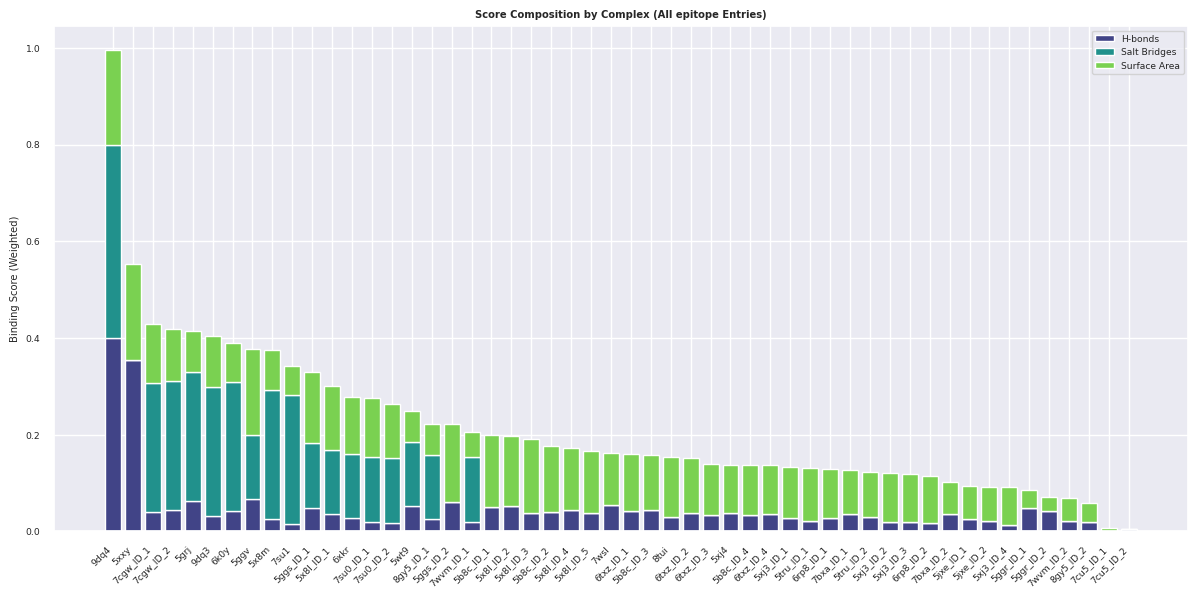

In [643]:
# Sort by binding score again
top = df_sorted_bs.sort_values("binding_score", ascending=False)

# viridis colormap
viridis = cm.get_cmap("viridis")
colors = viridis(np.linspace(0.2, 0.8, 3))

plt.figure(figsize=(12, 6))

# Plot H-bonds
plt.bar(
    top["structure_id"],
    top["num_hydrogen_bonds"] * 0.4,
    label="H-bonds",
    color=colors[0],
    bottom=0
)

# Plot Salt Bridges
plt.bar(
    top["structure_id"],
    top["num_salt_bridges"] * 0.4,
    label="Salt Bridges",
    color=colors[1],
    bottom=top["num_hydrogen_bonds"] * 0.4
)

# Plot Surface Area
plt.bar(
    top["structure_id"],
    top[f"{section}_area"] * 0.2,
    label="Surface Area",
    color=colors[2],
    bottom=(top["num_hydrogen_bonds"] + top["num_salt_bridges"]) * 0.4
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Binding Score (Weighted)")
plt.title(f"Score Composition by Complex (All {section} Entries)")
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section}_binding_affinity_score.pdf", bbox_inches="tight")
plt.show()




# Sequences Paratope/Epitope 

In [ ]:
# not unqiue sequences
# Input settings
root_folder = "structures"
cutoff_distance = 5.0 
section = 'paratope' # 'paratope' or 'epitope' please select one of the two sections
results = []

# Ensure extracted_list is defined
if 'extracted_list' not in locals():
    extracted_list = []  # Replace with actual data

# Loop through all extracted entries
for pdb_id, h_chain, l_chain, ag_chain in extracted_list:
    pdb_path = None
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower() == f"{pdb_id.lower()}.pdb":
                pdb_path = os.path.join(dirpath, file)
                break
        if pdb_path:
            break

    if not pdb_path:
        print(f"Skipping {pdb_id}: PDB file not found")
        continue
    else:
        print(f"Processing {pdb_id}...")

    cmd.reinitialize()
    cmd.load(pdb_path)

    # Define selections
    cmd.select("antibody", f"chain {h_chain}+{l_chain}")
    cmd.select("antigen", f"chain {ag_chain}")
    if section == 'paratope':
        cmd.select(f"{section}", f"antibody within {cutoff_distance} of antigen")
    else:
        cmd.select(f"{section}", f"antigen within {cutoff_distance} of antibody")

    # Extract unique residues from epitope
    model = cmd.get_model(f"{section}")
    seen = set()
    residues = []
    for atom in model.atom:
        res_id = (atom.chain, atom.resi)
        if res_id not in seen:
            seen.add(res_id)
            residues.append(atom.resn)

    sequence = ''.join(seq1(res) for res in residues if res != "HOH")

    # Collect results
    results.append({
        "pdb_id": pdb_id,
        "H_chain": h_chain,
        "L_chain": l_chain,
        "antigen_chain": ag_chain,
        f"{section}_sequence": sequence,
        "folder": os.path.basename(dirpath)
    })

# Convert to DataFrame
df_seq = pd.DataFrame(results)

# Assign unique structure_id 
df_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
id_frequencies = Counter(df_seq["pdb_id"])
id_tracker = defaultdict(int)

structure_ids = []
for pdb_id in df_seq["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}_ID_{id_tracker[pdb_id]}")

df_seq["structure_id"] = structure_ids

# Save CSV
df_seq.to_csv(f"{section}_sequences_summary.csv", index=False)
print(f"Summary table saved to '{section}_sequences_summary.csv'")

# Save FASTA
with open(f"{section}_sequences.fasta", "w") as f:
    for _, row in df_seq.iterrows():
        f.write(f">{row['structure_id']}\n{row[f'{section}_sequence']}\n")

print(f"FASTA file saved to '{section}_sequences.fasta'")

# Add sequence to df_sorted

df_sorted_seq = df_seq.sort_values(by=["folder", f"{section}_sequence"], ascending=[True, False]).copy()
   


Processing 5b8c...
Processing 5xj3...
Processing 7wvm...
Processing 7su0...
Processing 7cu5...
Processing 7bxa...
Processing 5x8l...
Processing 5ggs...
Processing 8gy5...
Processing 9dq3...
Processing 5tru...
Processing 5ggr...
Processing 5xj4...
Processing 6txz...
Processing 5x8m...
Processing 5b8c...
Processing 6xkr...
Processing 8gy5...
Processing 7bxa...
Processing 7cgw...
Processing 6txz...
Processing 7cu5...
Processing 5wt9...
Processing 5x8l...
Processing 6k0y...
Processing 5x8l...
Processing 5jxe...
Processing 7su0...
Processing 5xj3...
Processing 8tui...
Processing 5ggr...
Processing 6rp8...
Processing 5b8c...
Processing 5xxy...
Processing 7wsl...
Processing 5jxe...
Processing 9dq4...
Processing 7wvm...
Processing 5xj3...
Processing 7su1...
Processing 5tru...
Processing 5b8c...
Processing 6rp8...
Processing 5x8l...
Processing 6txz...
Processing 6txz...
Processing 5xj3...
Processing 5grj...
Processing 5ggs...
Processing 5ggv...
Processing 5x8l...
Processing 7cgw...
Summary tabl

## Identiy Matrix

In [645]:
# Load sequences
records = list(SeqIO.parse(f"{section}_sequences.fasta", "fasta"))

# Initialize identity matrix
matrix = []

# Compare each pair
for r1 in records:
    row = []
    for r2 in records:
        alignments = pairwise2.align.globalxx(r1.seq, r2.seq) # Align two sequences (whole sequence)
        best = alignments[0]
        identity = best.score / max(len(r1.seq), len(r2.seq)) * 100  # identiy in % -> (number of matches) / (length of longer sequence) × 100
        row.append(round(identity, 2))
    matrix.append(row)

# Create a DataFrame
ids = [rec.id for rec in records]
df_identity = pd.DataFrame(matrix, index=ids, columns=ids)

# Save & show
df_identity.to_csv(f"{section}_sequence_comparison_matrix.csv")
print(f" Sequence identity matrix saved to '{section}_sequence_comparison_matrix.csv'")
print(df_identity)


 Sequence identity matrix saved to 'epitope_sequence_comparison_matrix.csv'
           6rp8_ID_1    9dq3  6rp8_ID_2  5xj3_ID_1  5xj3_ID_2  5xj3_ID_3  \
6rp8_ID_1     100.00   84.62      88.46      76.92      84.62      88.46   
9dq3           84.62  100.00      91.30      78.26      79.17      80.00   
6rp8_ID_2      88.46   91.30     100.00      82.61      87.50      84.00   
5xj3_ID_1      76.92   78.26      82.61     100.00      91.67      88.00   
5xj3_ID_2      84.62   79.17      87.50      91.67     100.00      96.00   
5xj3_ID_3      88.46   80.00      84.00      88.00      96.00     100.00   
5ggv           70.97   70.97      67.74      64.52      70.97      74.19   
5xj3_ID_4      80.77   79.17      83.33      91.67      95.83      92.00   
9dq4           56.25   53.12      50.00      50.00      50.00      53.12   
7su0_ID_1      96.15   84.62      84.62      76.92      80.77      84.62   
7su0_ID_2      89.29   78.57      82.14      75.00      82.14      85.71   
5tru_ID_1   

## Heatmap

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/3448787762.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{x:.0f}")


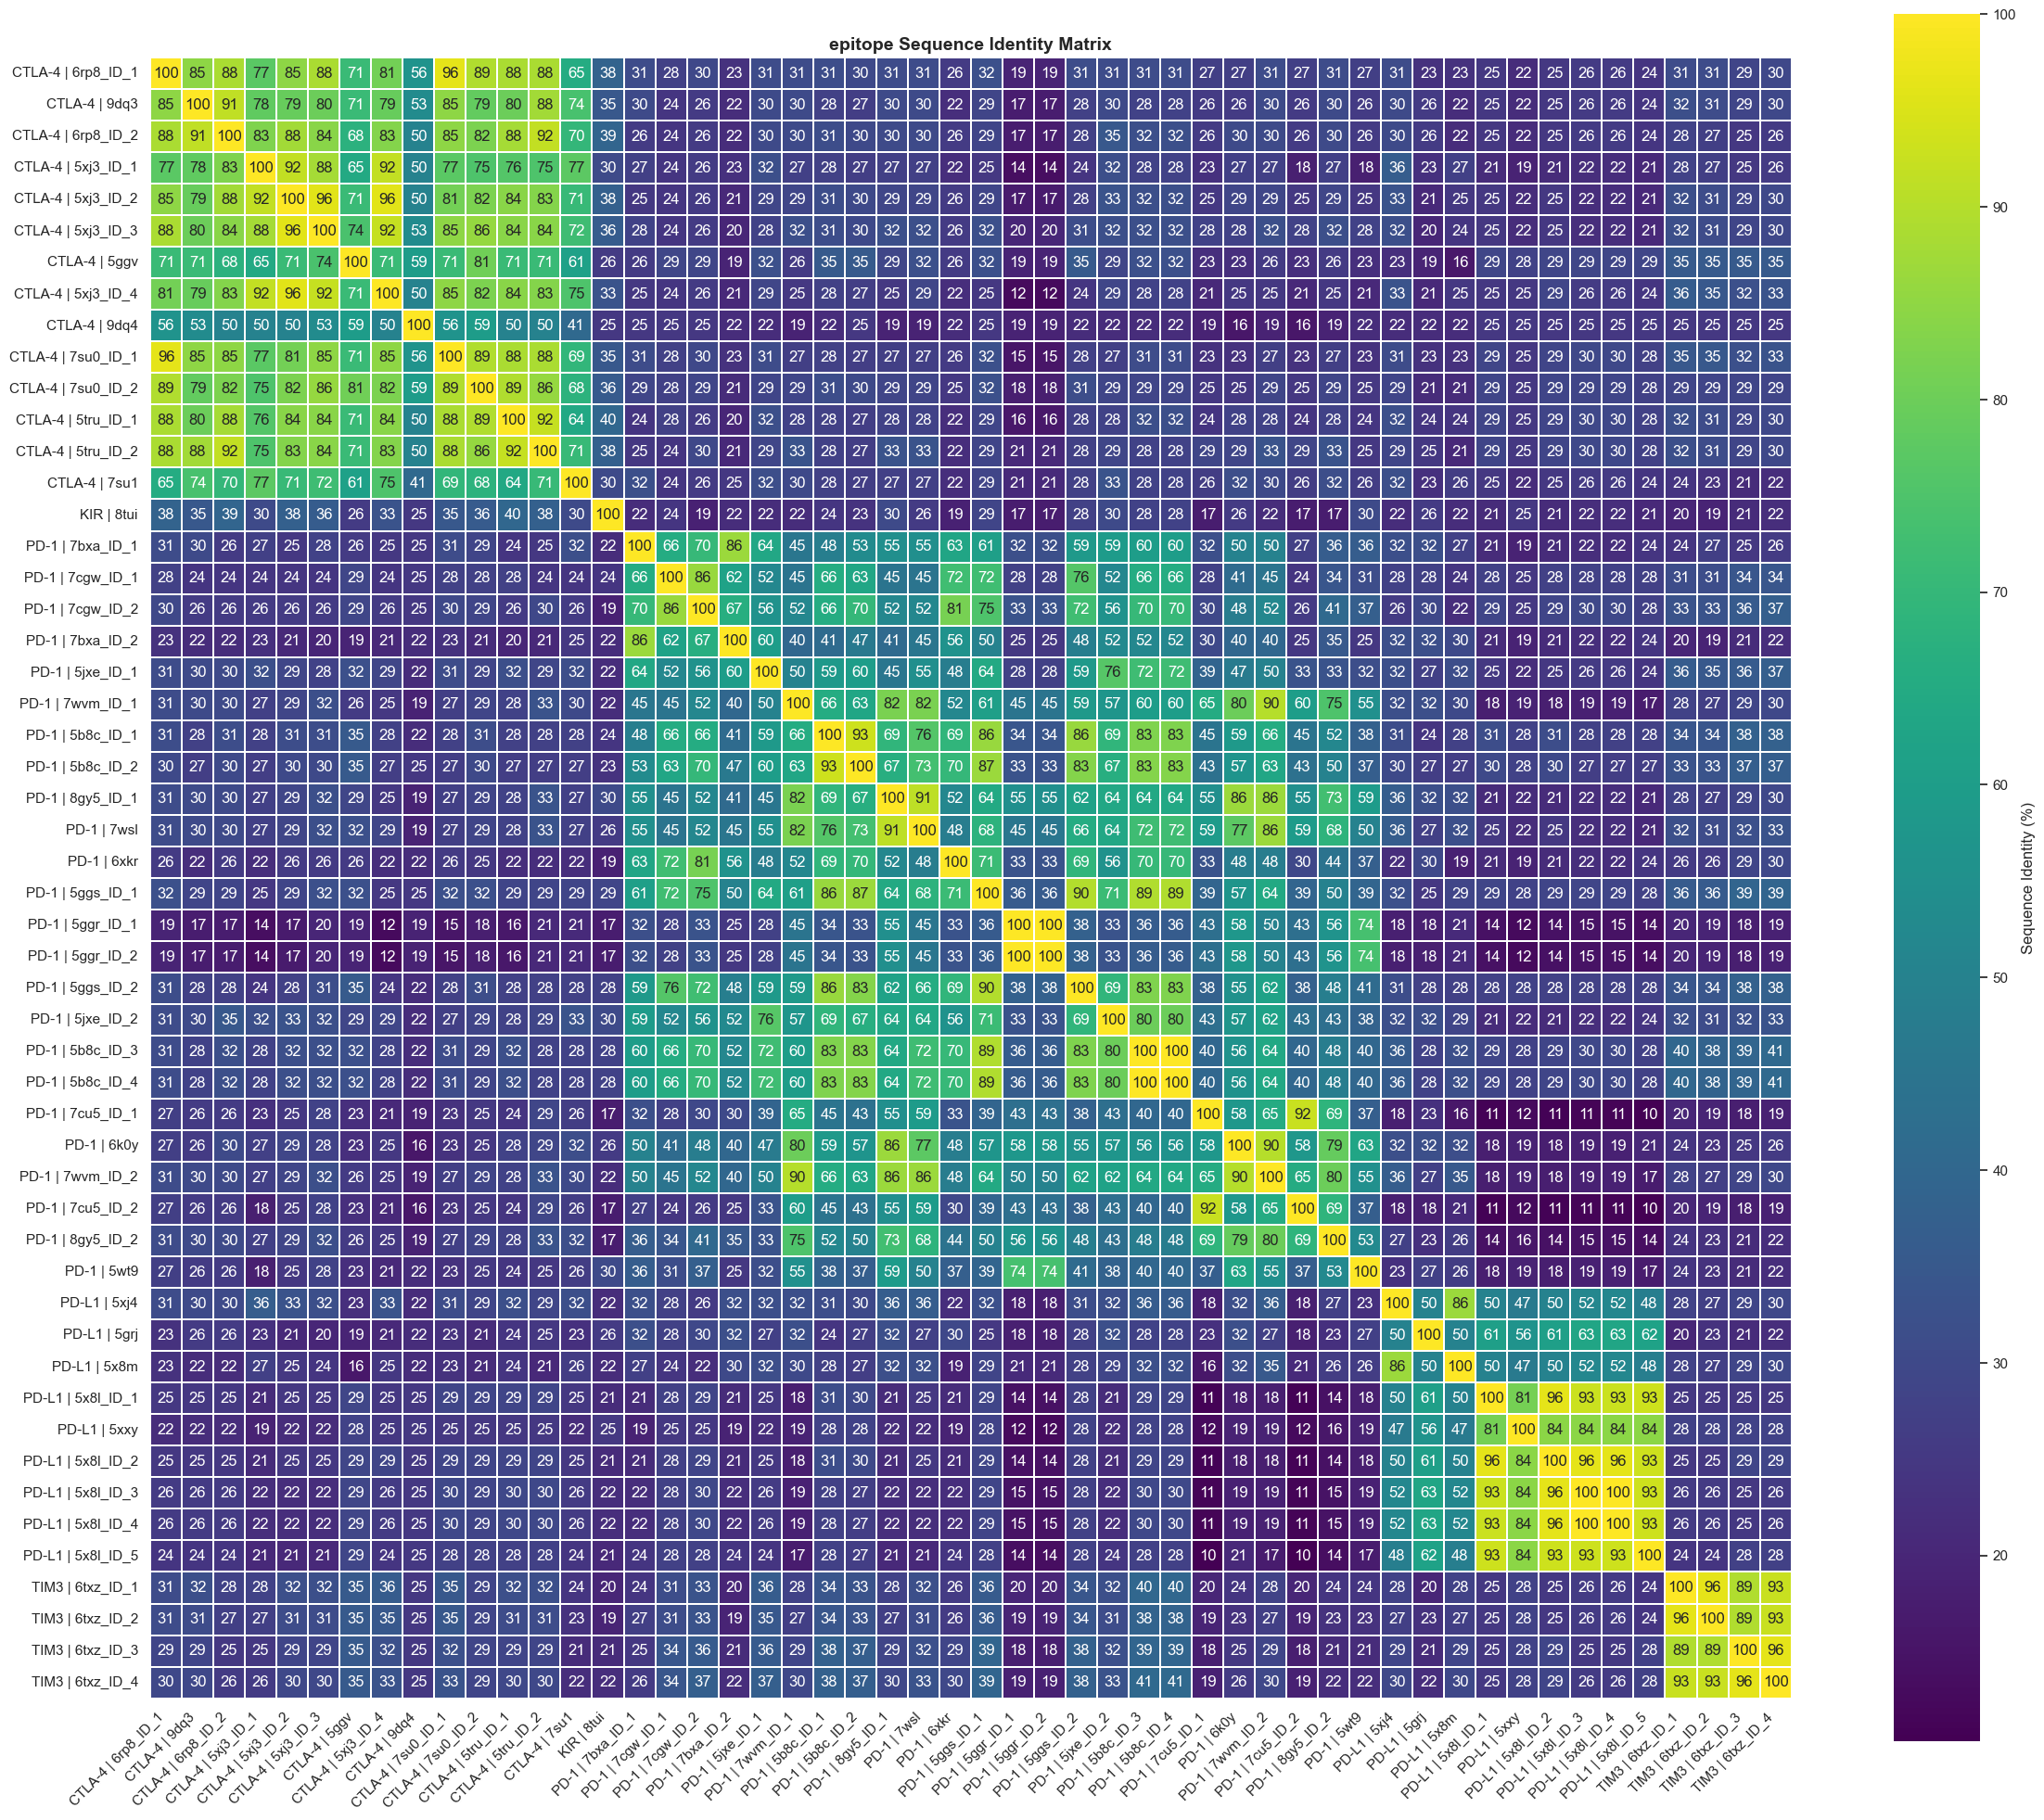

Cleaned-up heatmap saved as 'epitope_identity_heatmap_final.pdf'


In [646]:
checkpoints = ['PD-1', 'PD-L1', 'CTLA-4', 'KIR', 'LAG3', 'TIM3']

pdb_ids = {
    'PD-1': pd1['pdb'].unique().tolist(), # mit variable funktioniert unique nicht
    'PD-L1': pdl1['pdb'].unique().tolist(),
    'CTLA-4': ctla4['pdb'].unique().tolist(),
    'KIR': kir['pdb'].unique().tolist(),
    'LAG3': lag3['pdb'].unique().tolist(),
    'TIM3': tim3['pdb'].unique().tolist(),
}

# Create mapping from PDB ID → Checkpoint
pdb_to_checkpoint = {}
for checkpoint, pdb_list in pdb_ids.items():
    for pdb in pdb_list:
        pdb_to_checkpoint[pdb.lower()] = checkpoint

# Update row and column labels using base PDB ID
def get_checkpoint_label(pdb_id):
    '''welche werte,...'''

    base_id = pdb_id.lower().split('_')[0]  # e.g. "5x8l_ID_1" → "5x8l"
    checkpoint = pdb_to_checkpoint[base_id]
    return f"{checkpoint} | {pdb_id}"

df_identity = df_identity.copy()
df_identity.index = [get_checkpoint_label(p) for p in df_identity.index]
df_identity.columns = [get_checkpoint_label(p) for p in df_identity.columns]



annot_data = df_identity.applymap(lambda x: f"{x:.0f}")
mask = None

plt.figure(figsize=(24, 20))
sns.set(style="white", font_scale=1.0)

ax = sns.heatmap(
    df_identity, 
    annot=annot_data, 
    fmt="", 
    cmap="viridis", 
    mask=mask,
    square=True, 
    linewidths=0.3, 
    cbar_kws={"label": "Sequence Identity (%)"}
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title(f"{section} Sequence Identity Matrix", fontsize=14)
plt.tight_layout()

plt.savefig(f"plots/structural_analysis/{section}_identity_heatmap_final.pdf", dpi=300)
plt.show()

print(f"Cleaned-up heatmap saved as '{section}_identity_heatmap_final.pdf'")

## Clustermap

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/3285477103.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")


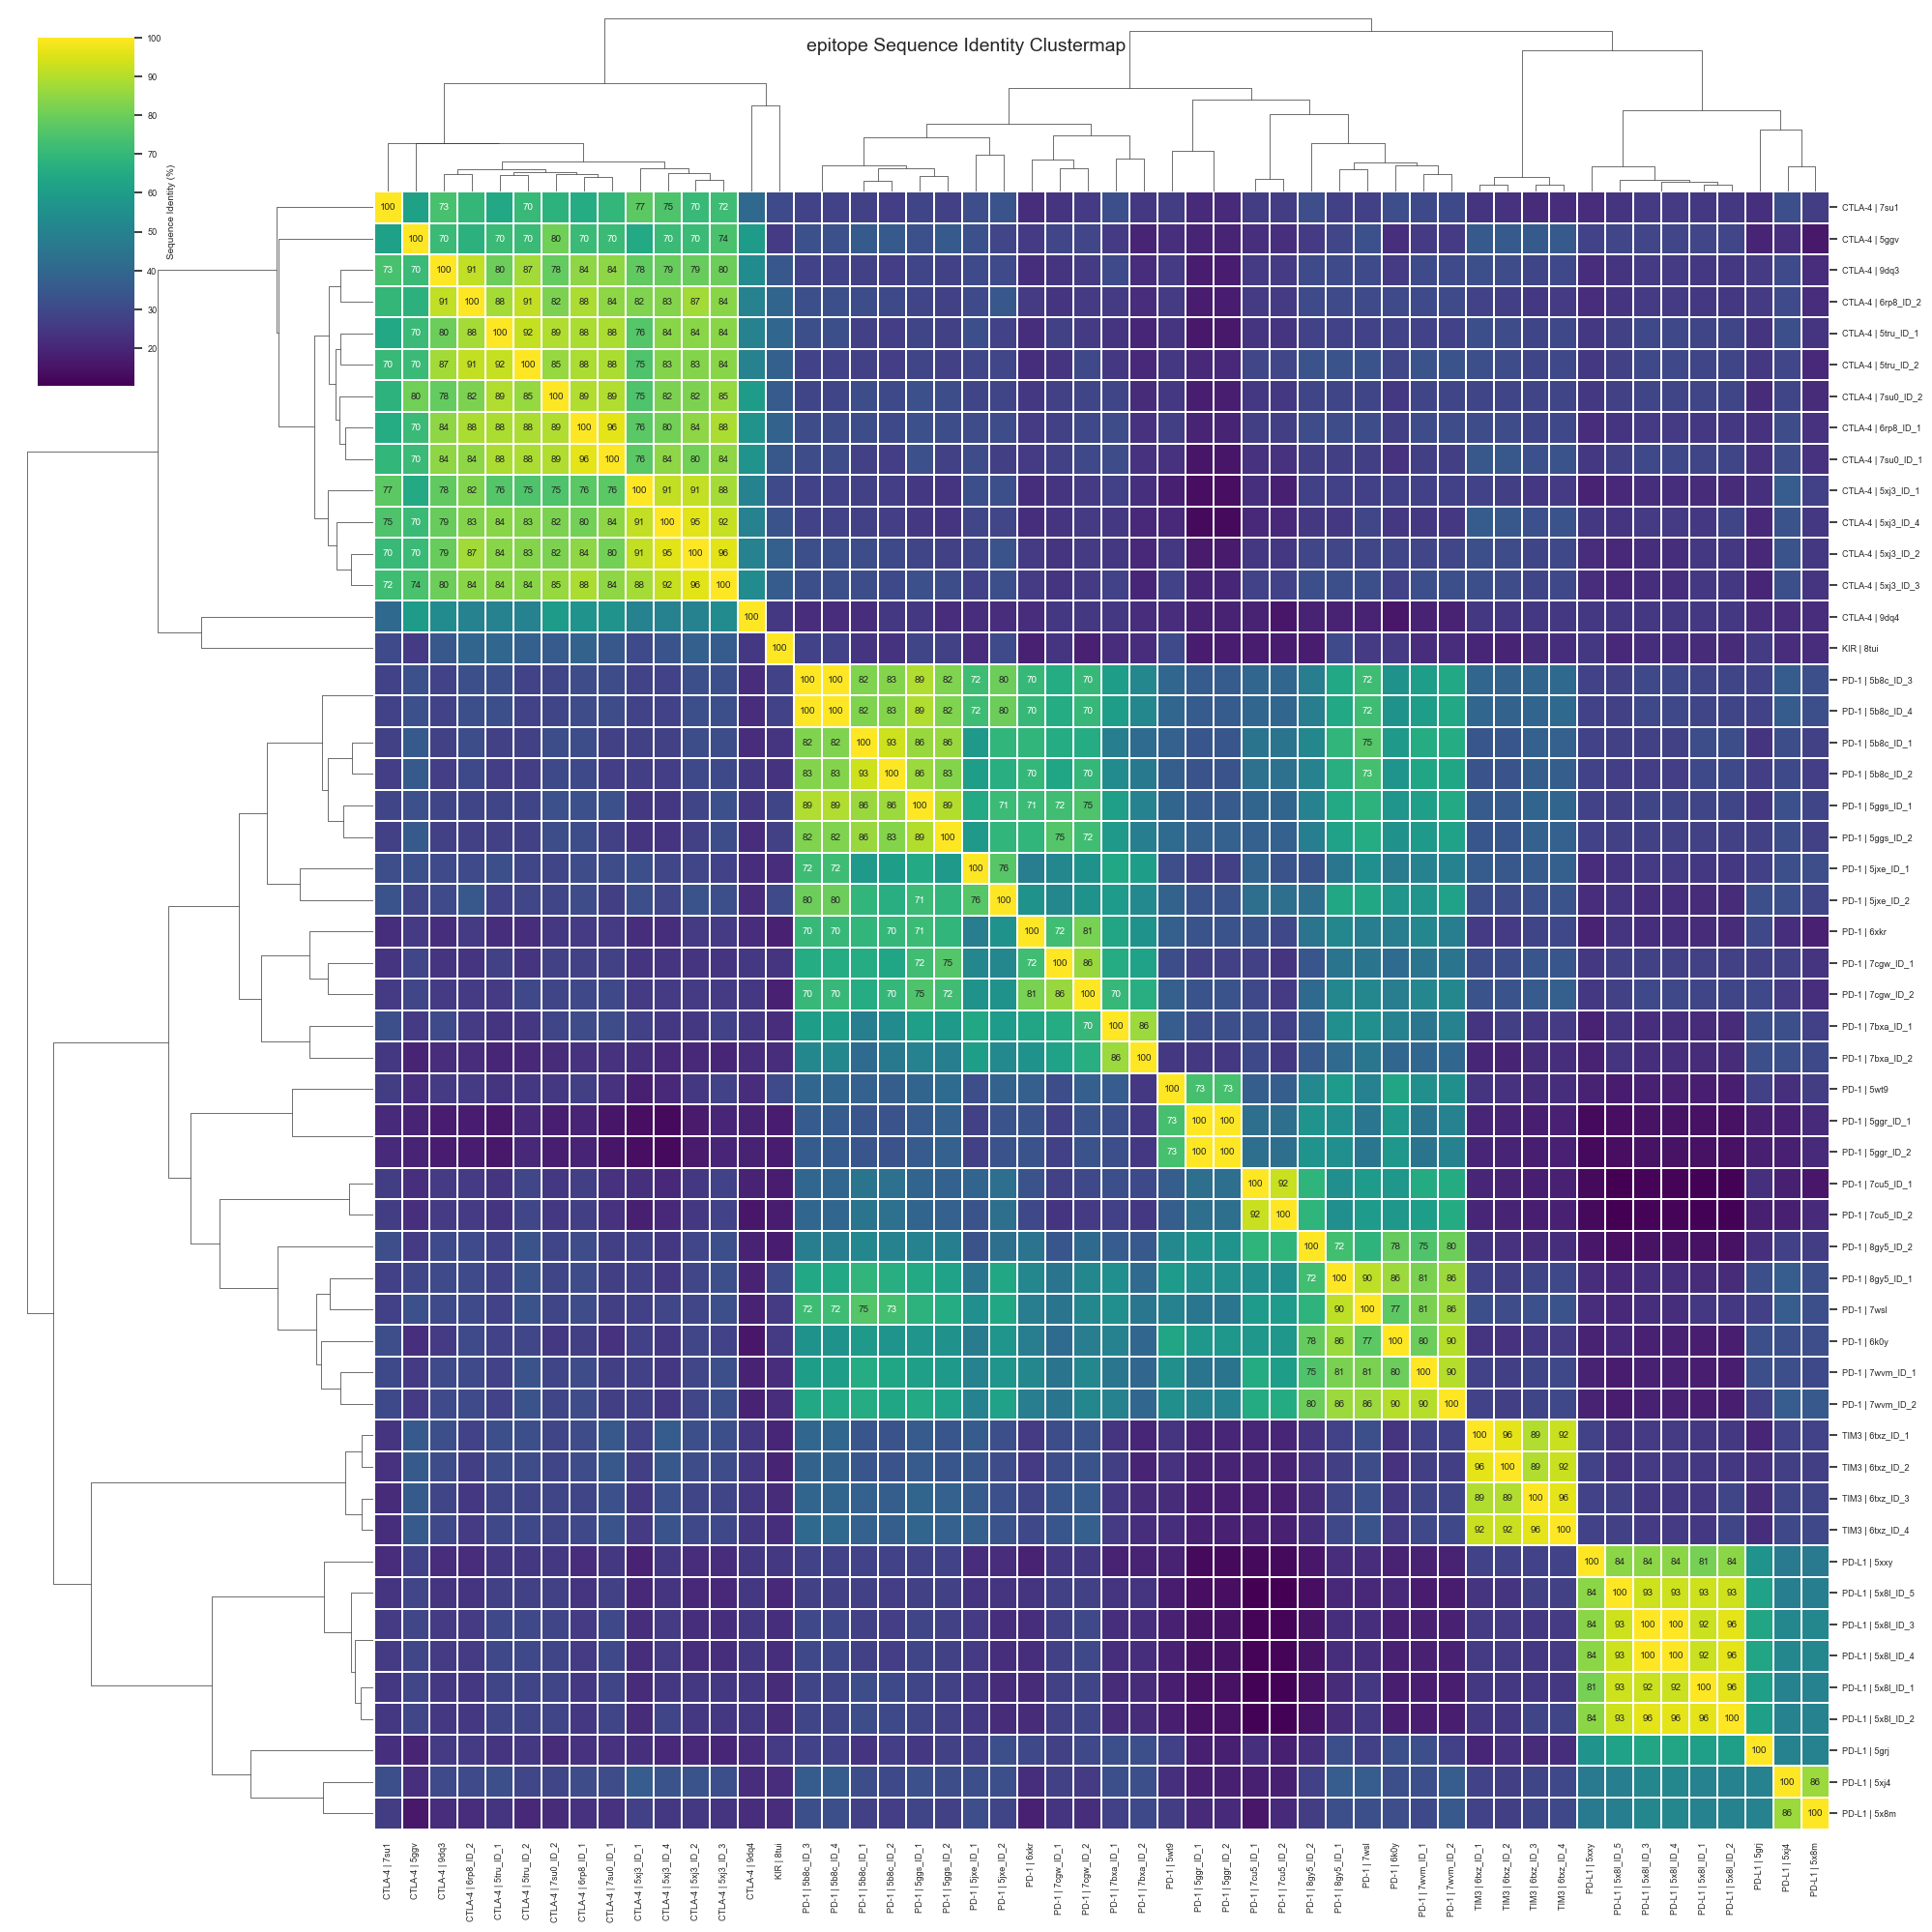

In [647]:
# annotate only high identities
annot_data = df_identity.applymap(lambda x: f"{int(x)}" if x >= 70 else "")

# clustermap
sns.set(font_scale=0.6)  # smaller font for big matrices
g = sns.clustermap(
    df_identity,
    cmap="viridis",
    figsize=(20, 20),
    annot=annot_data,
    fmt="",
    linewidths=0.3,
    cbar_kws={"label": "Sequence Identity (%)"},
    dendrogram_ratio=(.2, .1),  # ratio for row/col dendrograms
    xticklabels=True,
    yticklabels=True
)

#save 
g.fig.suptitle(f"{section} Sequence Identity Clustermap", fontsize=14)
plt.savefig(f"plots/structural_analysis/{section}_clustermap.pdf", dpi=300, bbox_inches="tight")
plt.show()


## Plotting Sequence Length Paratope/Epitope

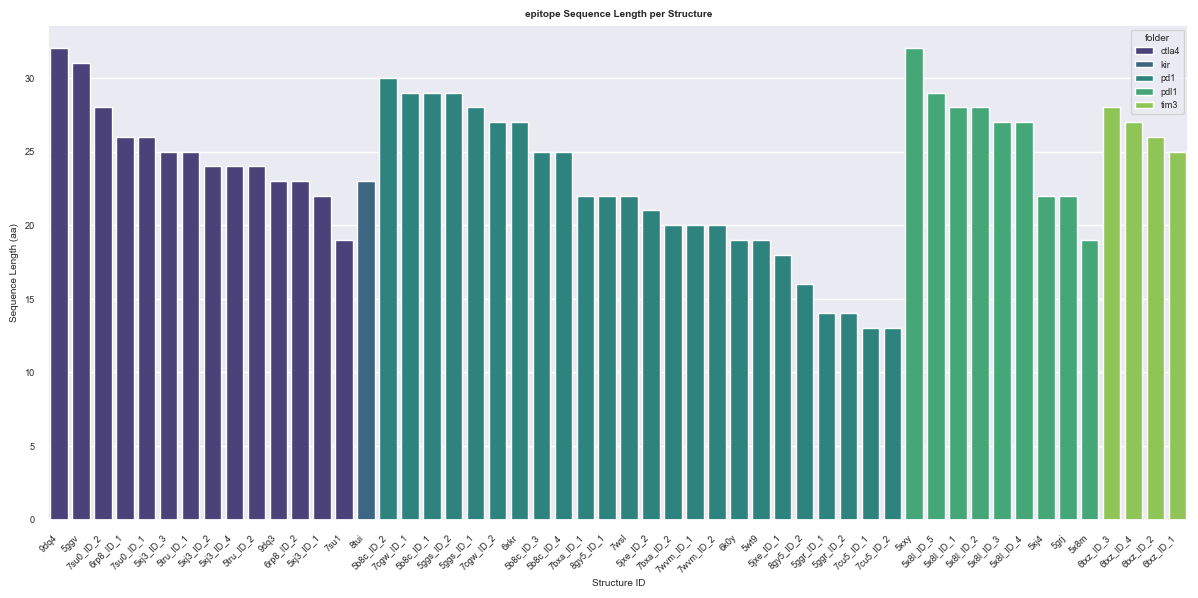

In [648]:
# Add column with sequence length
df_seq[f"{section}_length"] = df_seq[f"{section}_sequence"].str.len()

# Sort 
df_seq_sorted_by_length = df_seq.sort_values(by=["folder", f"{section}_length"], ascending=[True, False])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_seq_sorted_by_length, x="structure_id", y=f"{section}_length", hue="folder", dodge=False, palette="viridis")

plt.title(f"{section} Sequence Length per Structure")
plt.xlabel("Structure ID")
plt.ylabel("Sequence Length (aa)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"plots/structural_analysis/{section}_sequence_lengths.pdf", bbox_inches='tight')
plt.show()


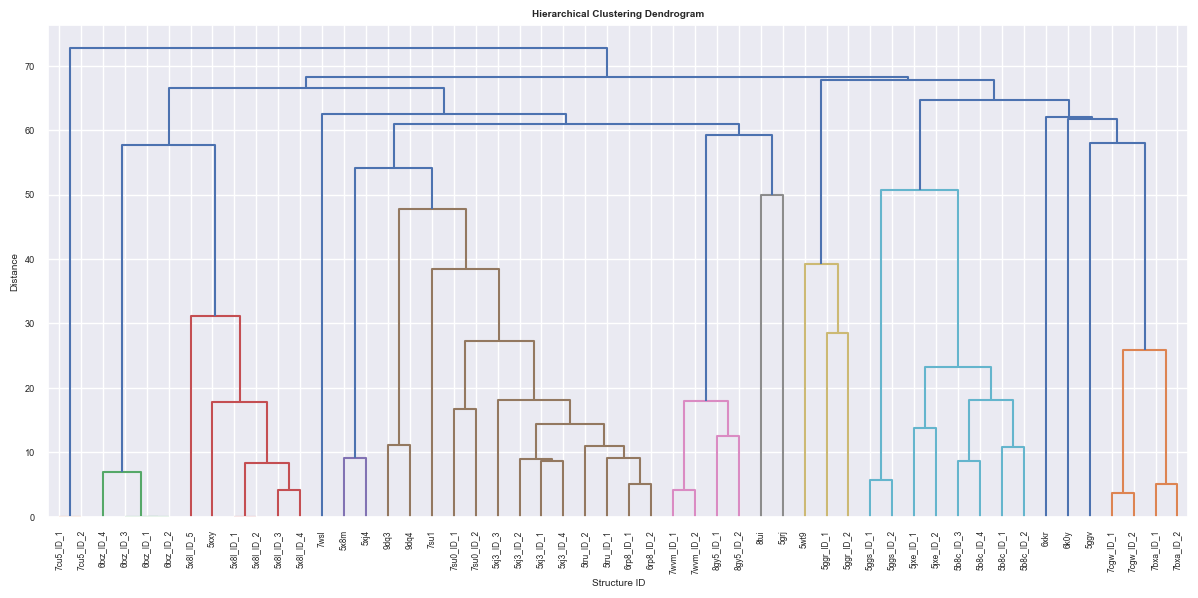

Cluster labels saved to 'cluster_labels.csv'


In [649]:
# === Step 1: Load the distance matrix ===
# Replace with your actual distance matrix CSV
df_distance = pd.read_csv("paratope_sequence_comparison_matrix.csv", index_col=0)

# === Step 2: Convert similarity to distance if needed ===
# If your matrix contains similarity (e.g. % identity), convert it:
df_dist = 100 - df_distance  # assuming 100% is max similarity

# === Step 3: Condense the distance matrix ===
# Hierarchical clustering needs a condensed distance matrix (lower triangle)
condensed_dist = df_dist.values[np.triu_indices_from(df_dist, k=1)]

# === Step 4: Perform hierarchical clustering ===
Z = linkage(condensed_dist, method='average')  # or 'ward', 'single', etc.

# === Step 5: Assign clusters ===
# Adjust t or n_clusters as needed
n_clusters = 6
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# === Step 6: Create a labeled DataFrame ===
df_labels = pd.DataFrame({
    'structure_id': df_dist.index,
    'cluster': clusters
})

# === Step 7: Plot dendrogram ===
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_dist.index.tolist(), leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Structure ID")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# === Step 8: Save results ===
df_labels.to_csv("cluster_labels.csv", index=False)
print("Cluster labels saved to 'cluster_labels.csv'")


In [650]:
# Load data
df_struct = pd.read_csv(f"{section}_surface_hbonds_salt_bridges_summary.csv")

# Create structure_id in df_struct
id_frequencies = Counter(df_struct["pdb_id"])
id_tracker = defaultdict(int)
structure_ids = []
for pdb_id in df_struct["pdb_id"]:
    if id_frequencies[pdb_id] == 1:
        structure_ids.append(pdb_id)
    else:
        id_tracker[pdb_id] += 1
        structure_ids.append(f"{pdb_id}ID{id_tracker[pdb_id]}")
df_struct["structure_id"] = structure_ids

# remove duplicates from df_norm if needed
df_norm = df_norm.drop_duplicates(subset="pdb_id")

# Merge everything
all_df = pd.merge(df_struct, df_sorted_seq[["structure_id", f"{section}_sequence"]], on="structure_id", how="left")
all_df = pd.merge(all_df, df_norm[["pdb_id", "binding_score"]], on="pdb_id", how="left")

all_df.rename(columns={"folder": "checkpoint"}, inplace=True)

# Save
all_df.to_csv(f"structural_{section}_all_information_final.csv", index=False)

# Do cluster have different binding affinities? 

In [651]:
manual_clusters = {
    "Cluster 1": ["5x8m", "5xj4", "9dq3", "9dq4", "7su1", "7su0", "5xj3", "6rp8", "5tru" ],
    "Cluster 2": ["6txz"],
    "Cluster 3": ["5xB1", "5xxy"],
    "Cluster 4": ["5ggs", "5jxe", "5b8c"],
    "Cluster 5": ["7wvm", "8gy5"],
    "Cluster 6": ["7cgw", "7bxa"],
    "Cluster 7": ["5wt9", "5ggr"]
}


# Convert Cluster-Dict in List
cluster_rows = []
for cluster_name, pdb_list in manual_clusters.items():
    for pdb in pdb_list:
        cluster_rows.append({"pdb_id": pdb, "cluster": cluster_name})

# Dataframe 
cluster_df = pd.DataFrame(cluster_rows)

# Merge with main df
merged_df = cluster_df.merge(all_df[["pdb_id", "binding_score", "checkpoint"]], on="pdb_id", how="left")

print(merged_df)

   pdb_id    cluster  binding_score checkpoint
0    5x8m  Cluster 1       0.374642       pdl1
1    5xj4  Cluster 1       0.138094       pdl1
2    9dq3  Cluster 1       0.404239      ctla4
3    9dq4  Cluster 1       0.995573      ctla4
4    7su1  Cluster 1       0.341447      ctla4
5    7su0  Cluster 1       0.276012      ctla4
6    7su0  Cluster 1       0.276012      ctla4
7    5xj3  Cluster 1       0.132534      ctla4
8    5xj3  Cluster 1       0.132534      ctla4
9    5xj3  Cluster 1       0.132534      ctla4
10   5xj3  Cluster 1       0.132534      ctla4
11   6rp8  Cluster 1       0.113497      ctla4
12   6rp8  Cluster 1       0.113497      ctla4
13   5tru  Cluster 1       0.130823      ctla4
14   5tru  Cluster 1       0.130823      ctla4
15   6txz  Cluster 2       0.152117       tim3
16   6txz  Cluster 2       0.152117       tim3
17   6txz  Cluster 2       0.152117       tim3
18   6txz  Cluster 2       0.152117       tim3
19   5xB1  Cluster 3            NaN        NaN
20   5xxy  Cl

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/1597252996.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")


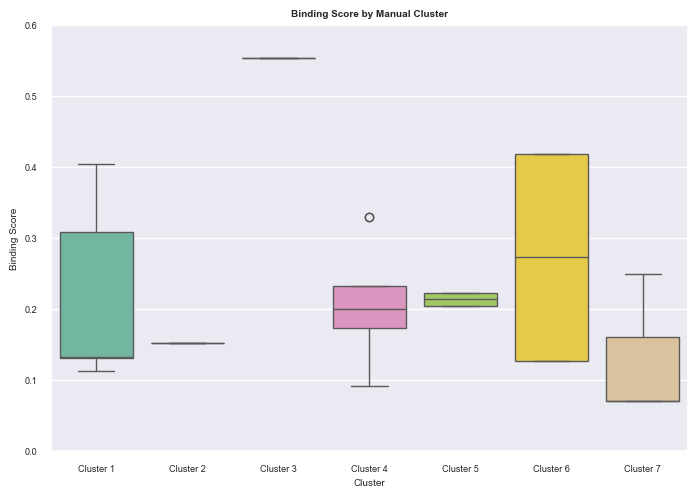

In [652]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x="cluster", y="binding_score", palette="Set2")

plt.title("Binding Score by Manual Cluster")
plt.xlabel("Cluster")
plt.ylabel("Binding Score")
plt.tight_layout()
plt.ylim(0, 0.6)

plt.savefig(f"plots/structural_analysis/{section}_binding_score_by_cluster.pdf", bbox_inches='tight')


In [653]:

# Group binding scores by cluster
grouped_scores = [
    group["binding_score"].dropna().values
    for name, group in merged_df.groupby("cluster")
]

# Kruskal–Wallis-Test
stat, p = kruskal(*grouped_scores)

print(f"Kruskal–Wallis-Test: H = {stat:.3f}, p = {p:.4e}")


Kruskal–Wallis-Test: H = 5.947, p = 4.2914e-01


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


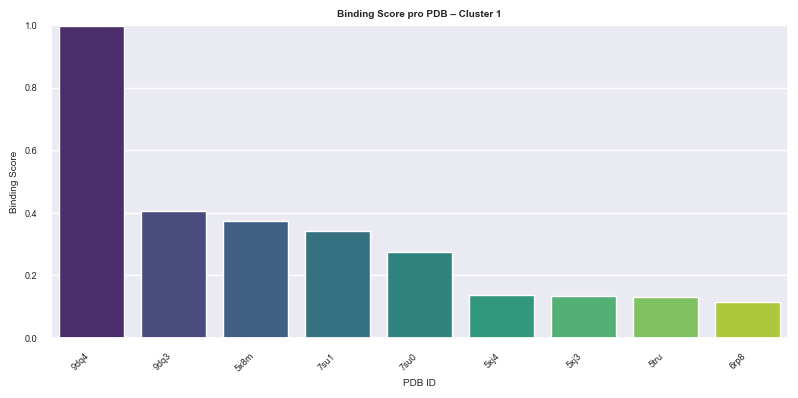

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


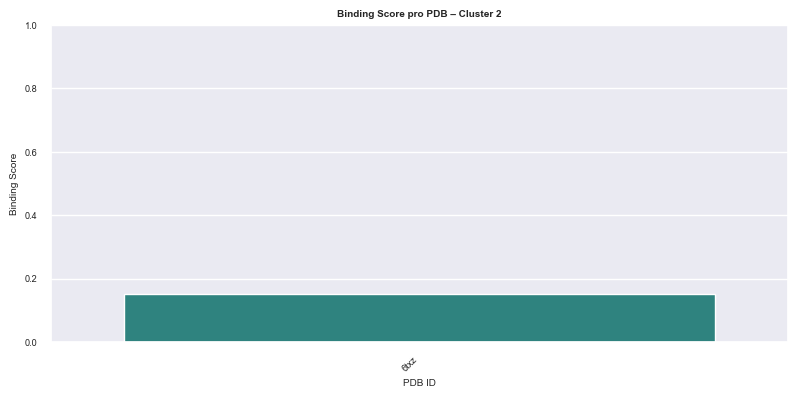

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


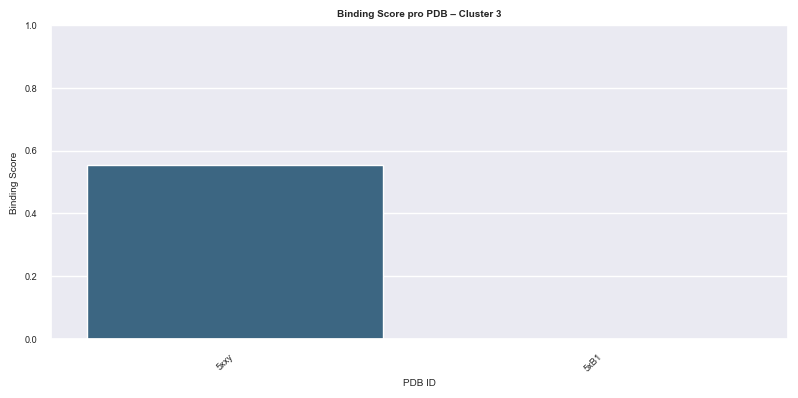

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


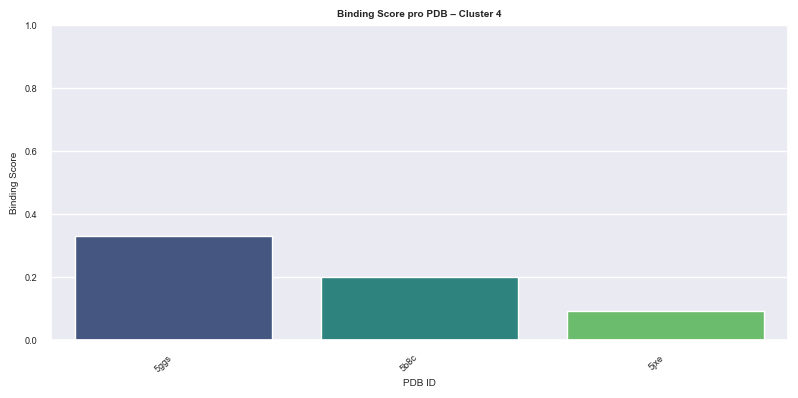

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


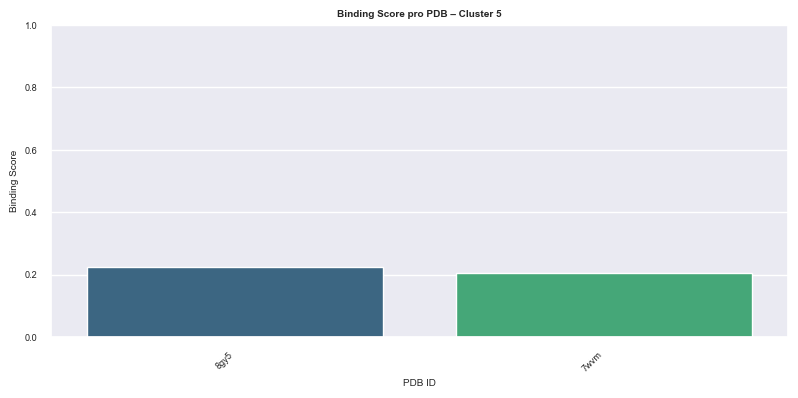

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


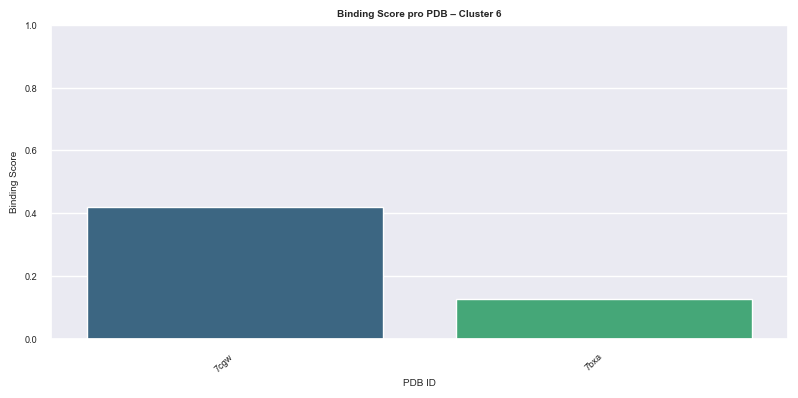

/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2160967823.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")


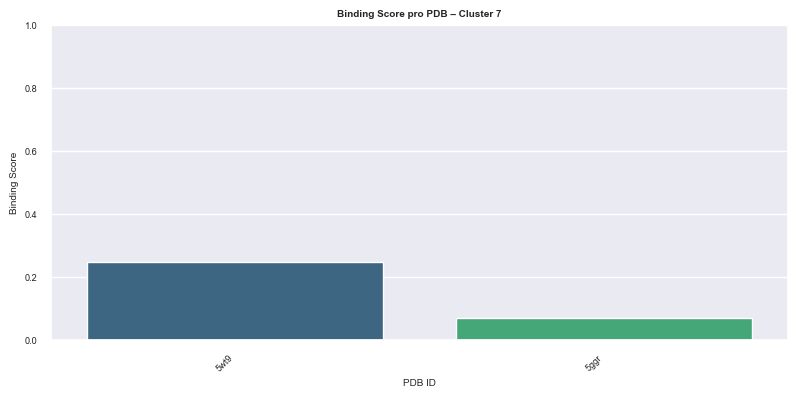

In [654]:
clusters = merged_df["cluster"].unique()

# Plot per Cluster
for cluster_name in clusters:
    subset = merged_df[merged_df["cluster"] == cluster_name].sort_values("binding_score", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=subset, x="pdb_id", y="binding_score", palette="viridis")
    plt.ylim(0, 1.0)
    plt.title(f"Binding Score pro PDB – {cluster_name}")
    plt.xlabel("PDB ID")
    plt.ylabel("Binding Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f'plots/structural_analysis/binding_score_per_pdb_{cluster_name}.pdf', bbox_inches = 'tight')
    plt.show()


Mann–Whitney U-Statistik: 60248.00
P-Wert: 0.7709


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/1681674784.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])


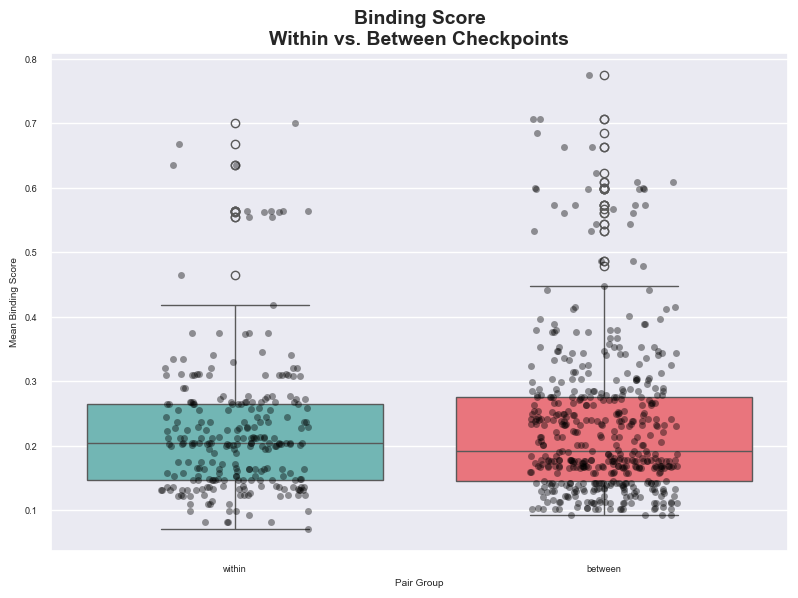

In [655]:
# Step 1: Drop NaNs in binding_score or checkpoint before pairing
clean_df = merged_df.dropna(subset=["binding_score", "checkpoint"])

# Step 2: Generate all pairwise combinations
pairs = []
for (p1, row1), (p2, row2) in combinations(clean_df.iterrows(), 2):
    score1 = row1["binding_score"]
    score2 = row2["binding_score"]

    if pd.notna(score1) and pd.notna(score2):
        pairs.append({
            "pdb_1": row1["pdb_id"],
            "pdb_2": row2["pdb_id"],
            "mean_binding": (score1 + score2) / 2,
            "same_checkpoint": row1["checkpoint"] == row2["checkpoint"]
        })

# Step 3: Create DataFrame and group labels
df_binding_pairs = pd.DataFrame(pairs)
df_binding_pairs = df_binding_pairs.dropna(subset=["mean_binding"])
df_binding_pairs["group"] = df_binding_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Step 4: Statistical test
within = df_binding_pairs[df_binding_pairs["group"] == "within"]["mean_binding"]
between = df_binding_pairs[df_binding_pairs["group"] == "between"]["mean_binding"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")

# Step 5: Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_binding_pairs, x="group", y="mean_binding", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_binding_pairs, x="group", y="mean_binding", color='black', alpha=0.4, jitter=0.2)

plt.title("Binding Score\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Mean Binding Score")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [656]:
df_identity.index = df_identity.index.str.lower()
df_identity.columns = df_identity.columns.str.lower()
merged_df["pdb_id"] = merged_df["pdb_id"].str.lower()
print(df_identity)

                    ctla-4 | 6rp8_id_1  ctla-4 | 9dq3  ctla-4 | 6rp8_id_2  \
ctla-4 | 6rp8_id_1              100.00          84.62               88.46   
ctla-4 | 9dq3                    84.62         100.00               91.30   
ctla-4 | 6rp8_id_2               88.46          91.30              100.00   
ctla-4 | 5xj3_id_1               76.92          78.26               82.61   
ctla-4 | 5xj3_id_2               84.62          79.17               87.50   
ctla-4 | 5xj3_id_3               88.46          80.00               84.00   
ctla-4 | 5ggv                    70.97          70.97               67.74   
ctla-4 | 5xj3_id_4               80.77          79.17               83.33   
ctla-4 | 9dq4                    56.25          53.12               50.00   
ctla-4 | 7su0_id_1               96.15          84.62               84.62   
ctla-4 | 7su0_id_2               89.29          78.57               82.14   
ctla-4 | 5tru_id_1               88.46          80.00               88.00   

In [657]:
pairs = []

# Extrahiere nur die echten PDB-IDs aus dem df_identity-Index
# Annahme: Format ist "checkpoint | pdb_id"
df_identity.index = df_identity.index.str.extract(r"\|\s*(.*)")[0]
df_identity.columns = df_identity.columns.str.extract(r"\|\s*(.*)")[0]

# Iteriere über alle PDB-Paare
for pdb1, pdb2 in combinations(df_identity.index, 2):
    if pdb1 not in merged_df["pdb_id"].values or pdb2 not in merged_df["pdb_id"].values:
        continue  # Wenn einer fehlt, skip
    
    identity = df_identity.loc[pdb1, pdb2]
    
    # Hole die Checkpoints
    cp1 = merged_df[merged_df["pdb_id"] == pdb1]["checkpoint"]
    cp2 = merged_df[merged_df["pdb_id"] == pdb2]["checkpoint"]
    
    if cp1.empty or cp2.empty:
        continue
    
    group1 = cp1.values[0]
    group2 = cp2.values[0]
    same_group = group1 == group2

    pairs.append({
        "pdb1": pdb1,
        "pdb2": pdb2,
        "identity": identity,
        "same_checkpoint": same_group
    })

# Speichern in DataFrame
df_pairs = pd.DataFrame(pairs)
print(df_pairs.head())


   pdb1  pdb2  identity  same_checkpoint
0  9dq3  9dq4     53.12             True
1  9dq3  7su1     73.91             True
2  9dq3  5wt9     26.09            False
3  9dq3  5xj4     30.43            False
4  9dq3  5x8m     21.74            False


In [658]:
from scipy.stats import mannwhitneyu

within = df_pairs[df_pairs["same_checkpoint"] == True]["identity"]
between = df_pairs[df_pairs["same_checkpoint"] == False]["identity"]

stat, p = mannwhitneyu(within, between, alternative="greater")
print(f"Mann–Whitney U-Statistik: {stat:.2f}")
print(f"P-Wert: {p:.4f}")


Mann–Whitney U-Statistik: 90.00
P-Wert: 0.0002


/var/folders/4b/v_2x0lss5_bfxdnbx8y02n6r0000gn/T/ipykernel_30636/2363169922.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])


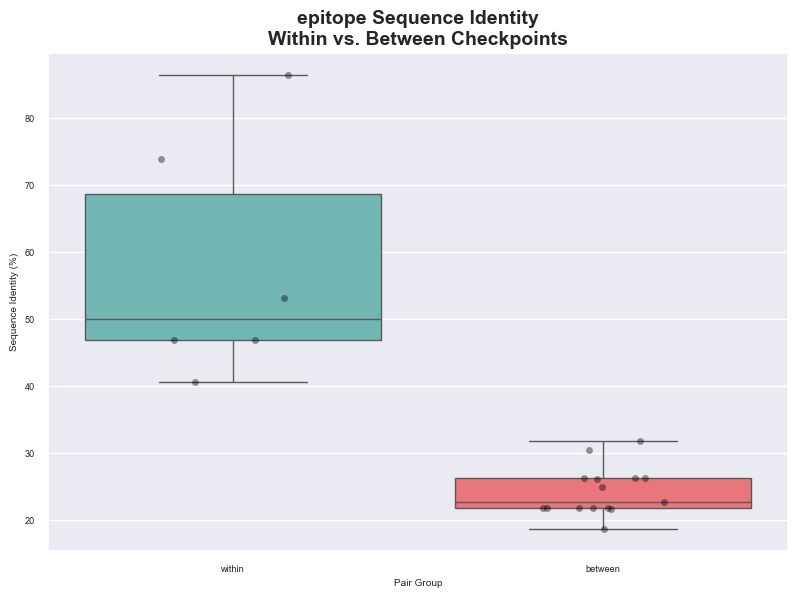

In [659]:
# Falls noch nicht vorhanden: 'same_checkpoint' als bool-Typ sichern
df_pairs["same_checkpoint"] = df_pairs["same_checkpoint"].astype(bool)

# Optional: Ersetze True/False durch beschreibende Labels
df_pairs["group"] = df_pairs["same_checkpoint"].map({True: "within", False: "between"})

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pairs, x="group", y="identity", palette=["#66c2bf", "#fc626c"])
sns.stripplot(data=df_pairs, x="group", y="identity", color='black', alpha=0.4, jitter=0.2)
plt.title(f"{section} Sequence Identity\nWithin vs. Between Checkpoints", fontsize=14)
plt.ylabel("Sequence Identity (%)")
plt.xlabel("Pair Group")
plt.tight_layout()
plt.show()


In [660]:
all_df

,pdb_id,H_chain,L_chain,antigen_chain,epitope_area,num_hydrogen_bonds,num_salt_bridges,checkpoint,structure_id,epitope_sequence,binding_score
0,5b8c,B,A,C,1872.029907,32,0,pd1,5b8cID1,NaN,0.200059
1,5xj3,D,E,F,1529.390869,20,0,ctla4,5xj3ID1,NaN,0.132534
2,7wvm,A,B,E,1114.703125,16,1,pd1,7wvmID1,NaN,0.204578
3,7su0,I,M,D,1668.169678,16,1,ctla4,7su0ID1,NaN,0.276012
4,7cu5,B,B,E,713.155029,8,0,pd1,7cu5ID1,NaN,0.003883
5,7bxa,B,C,A,1424.011963,24,0,pd1,7bxaID1,NaN,0.126700
6,5x8l,G,L,B,1699.881348,26,0,pdl1,5x8lID1,NaN,0.166189
7,5ggs,C,D,Y,1861.321899,31,1,pd1,5ggsID1,NaN,0.330068
8,8gy5,H,L,P,1210.948486,19,1,pd1,8gy5ID1,NaN,0.222825
9,9dq3,H,L,C,1538.336426,22,2,ctla4,9dq3,MHERLQVTEIKELMYPPYYLGIN,0.404239


In [661]:
wanted_best_pdbs = ['5xj4', '5x8m', '7bxa', '7cgw', '5b8c', '5ggs', '5jxe', '5x8l',
       '5xxy', '5wt9', '5ggr']

filtered_best_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

print(filtered_best_df)

filtered_best_df.to_csv('filtered_pdbs.csv', index=False)





   pdb_id H_chain L_chain antigen_chain  epitope_area  num_hydrogen_bonds  \
0    5b8c       B       A             C   1872.029907                  32   
5    7bxa       B       C             A   1424.011963                  24   
6    5x8l       G       L             B   1699.881348                  26   
7    5ggs       C       D             Y   1861.321899                  31   
11   5ggr       A       B             Y    934.019348                  28   
12   5xj4       H       L             A   1482.201538                  26   
14   5x8m       B       C             A   1354.155151                  19   
15   5b8c       E       D             F   1769.807129                  27   
18   7bxa       H       L             P   1238.410400                  24   
19   7cgw       H       L             P   1545.606567                  29   
22   5wt9       H       L             G   1204.926880                  33   
23   5x8l       H       M             C   1834.608643                  33   

In [662]:
wanted_worst_pdbs = ['7wsl', '7wvm', '8gy5', '5grj', '6rp8', '5xj3', '9dq4', '7su0',
       '5tru', '7su1', '9dq3']

filtered_worst_df = all_df[all_df['pdb_id'].isin(wanted_best_pdbs)]

print(filtered_worst_df)

filtered_worst_df.to_csv('filtered_pdbs.csv', index=False)

   pdb_id H_chain L_chain antigen_chain  epitope_area  num_hydrogen_bonds  \
0    5b8c       B       A             C   1872.029907                  32   
5    7bxa       B       C             A   1424.011963                  24   
6    5x8l       G       L             B   1699.881348                  26   
7    5ggs       C       D             Y   1861.321899                  31   
11   5ggr       A       B             Y    934.019348                  28   
12   5xj4       H       L             A   1482.201538                  26   
14   5x8m       B       C             A   1354.155151                  19   
15   5b8c       E       D             F   1769.807129                  27   
18   7bxa       H       L             P   1238.410400                  24   
19   7cgw       H       L             P   1545.606567                  29   
22   5wt9       H       L             G   1204.926880                  33   
23   5x8l       H       M             C   1834.608643                  33   